<a href="https://colab.research.google.com/github/22f3000969/Bank-Telemarketing-Success-Prediction-ML/blob/main/Predict_the_Success_of_Bank_telemarketing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/predict-the-success-of-bank-telemarketing/sample_submission.csv
/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv
/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv


# Library imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFE
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Data Loading

In [ ]:
train = pd.read_csv("/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv")
test = pd.read_csv("/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv")

# EDA

In [ ]:
train.head()

,last contact date,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,target
0,2009-04-17,26,blue-collar,married,secondary,no,647,yes,no,cellular,357,2,331,1,other,no
1,2009-10-11,52,technician,married,secondary,no,553,yes,no,telephone,160,1,-1,0,NaN,no
2,2010-11-20,44,blue-collar,married,secondary,no,1397,no,no,cellular,326,1,-1,0,NaN,no
3,2009-09-01,33,admin.,married,secondary,no,394,yes,no,telephone,104,3,-1,0,NaN,no
4,2008-01-29,31,entrepreneur,single,tertiary,no,137,no,no,cellular,445,2,-1,0,NaN,no


In [ ]:
test.head()

,last contact date,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome
0,2009-11-21,36,management,single,tertiary,no,7,no,no,NaN,20,1,-1,0,NaN
1,2010-02-04,30,unemployed,married,tertiary,no,1067,no,no,cellular,78,2,-1,0,NaN
2,2010-07-28,32,blue-collar,single,secondary,no,82,yes,no,cellular,86,4,-1,0,NaN
3,2010-06-09,38,admin.,married,primary,no,1487,no,no,NaN,332,2,-1,0,NaN
4,2008-03-02,59,management,married,tertiary,no,315,no,no,cellular,591,1,176,2,failure


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39211 entries, 0 to 39210
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   last contact date  39211 non-null  object
 1   age                39211 non-null  int64 
 2   job                38982 non-null  object
 3   marital            39211 non-null  object
 4   education          37744 non-null  object
 5   default            39211 non-null  object
 6   balance            39211 non-null  int64 
 7   housing            39211 non-null  object
 8   loan               39211 non-null  object
 9   contact            28875 non-null  object
 10  duration           39211 non-null  int64 
 11  campaign           39211 non-null  int64 
 12  pdays              39211 non-null  int64 
 13  previous           39211 non-null  int64 
 14  poutcome           9760 non-null   object
 15  target             39211 non-null  object
dtypes: int64(6), object(10)
memory usage: 4.

In [ ]:
train.describe()  # It describes only Numerical Columns

,age,balance,duration,campaign,pdays,previous
count,39211.000000,39211.000000,39211.000000,39211.000000,39211.000000,39211.000000
mean,42.120247,5441.781719,439.062789,5.108770,72.256051,11.826171
std,12.709352,16365.292065,769.096291,9.890153,160.942593,44.140259
min,18.000000,-8019.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,98.000000,109.000000,1.000000,-1.000000,0.000000
50%,40.000000,549.000000,197.000000,2.000000,-1.000000,0.000000
75%,50.000000,2030.000000,380.000000,4.000000,-1.000000,0.000000
max,95.000000,102127.000000,4918.000000,63.000000,871.000000,275.000000


* **Age:** Middle-aged population (mean 42), ranging from 18 to 95 years with moderate variability (std 12.7).
* **Balance:** Highly variable (std 16,365), with an average of $5441, some negative values ($-8019), and a maximum of $102,127.
* **Duration:** Average call duration is 439 seconds (~7 minutes), with most calls under 3 minutes (median 197) and a maximum of ~82 minutes.
* **Campaign:** Average of 5 contacts per client, with most receiving only 1 to 4; maximum is 63 contacts.
* **Pdays:** Majority have no prior contact (-1), with an average of 72 days and a maximum of 871 days since the last contact.
* **Previous:** Most clients had no prior contacts (median 0), but some were contacted up to 275 times.


In [ ]:
train.isna().sum()  # Checking Null Values

last contact date        0
age                      0
job                    229
marital                  0
education             1467
default                  0
balance                  0
housing                  0
loan                     0
contact              10336
duration                 0
campaign                 0
pdays                    0
previous                 0
poutcome             29451
target                   0
dtype: int64

In [ ]:
for column in train.columns:
    print(train[column].value_counts())

last contact date
2009-05-15    313
2008-05-15    301
2009-05-14    292
2010-05-15    292
2009-05-13    279
             ... 
2009-08-09      1
2008-08-30      1
2009-10-31      1
2009-07-26      1
2010-04-12      1
Name: count, Length: 1013, dtype: int64
age
32    1688
31    1629
33    1599
35    1571
34    1566
      ... 
18      44
92      41
87      40
85      39
95       2
Name: count, Length: 78, dtype: int64
job
blue-collar      7776
management       7462
technician       6078
admin.           4116
services         3325
self-employed    1862
retired          1824
entrepreneur     1805
unemployed       1685
housemaid        1656
student          1393
Name: count, dtype: int64
marital
married     22691
single      11250
divorced     5270
Name: count, dtype: int64
education
secondary    19584
tertiary     11615
primary       6545
Name: count, dtype: int64
default
no     36954
yes     2257
Name: count, dtype: int64
balance
0        2799
1         149
2         122
4         115
3   

In [ ]:
train.columns

Index(['last contact date', 'age', 'job', 'marital', 'education', 'default',
       'balance', 'housing', 'loan', 'contact', 'duration', 'campaign',
       'pdays', 'previous', 'poutcome', 'target'],
      dtype='object')

## Last contact date and target

In [ ]:
train['last contact date'] = pd.to_datetime(train['last contact date'])
train['month'] = train['last contact date'].dt.month
train['year'] = train['last contact date'].dt.year
train['weekday'] = train['last contact date'].dt.weekday


test['last contact date'] = pd.to_datetime(test['last contact date'])
test['month'] = test['last contact date'].dt.month
test['year'] = test['last contact date'].dt.year
test['weekday'] = test['last contact date'].dt.weekday

train.drop(columns=['last contact date'],inplace=True)
test.drop(columns=['last contact date'],inplace=True)

### month

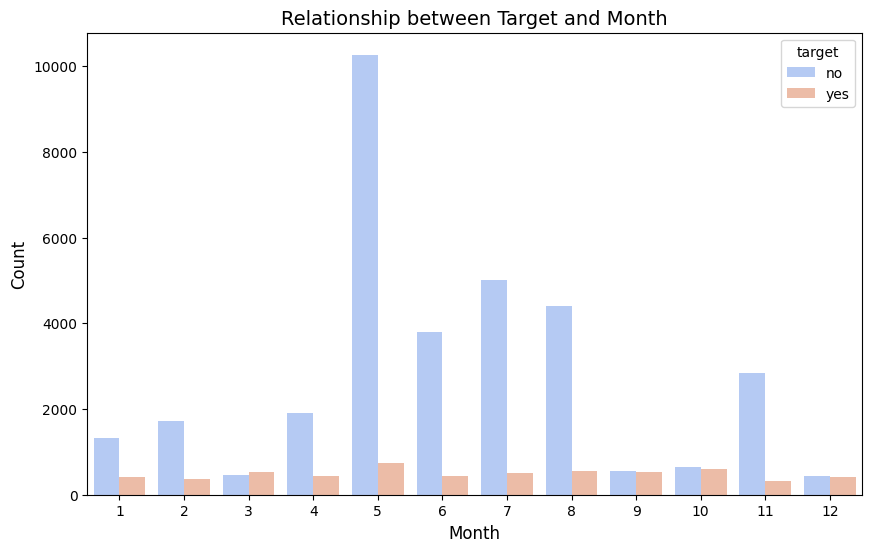

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='month', hue='target', data=train, palette="coolwarm")
plt.title('Relationship between Target and Month', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()


### year

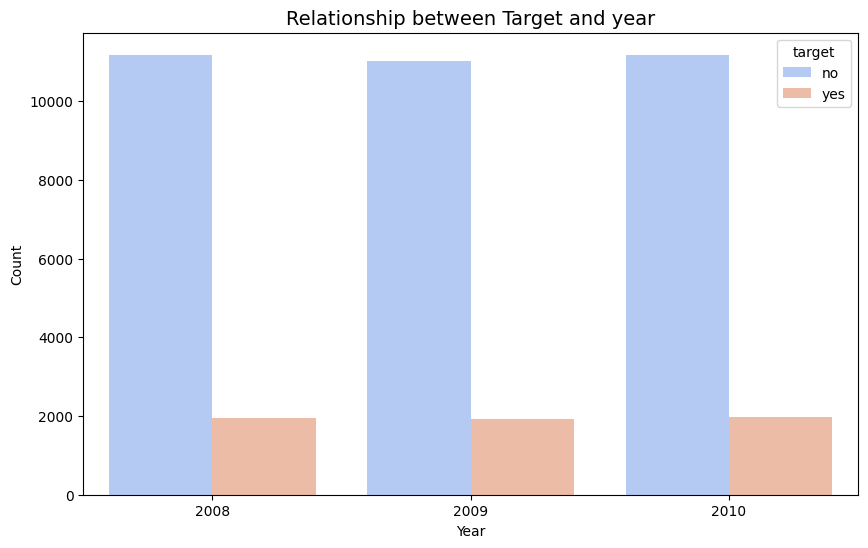

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='year', hue='target', data=train, palette="coolwarm")
plt.title('Relationship between Target and year', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

### weekday

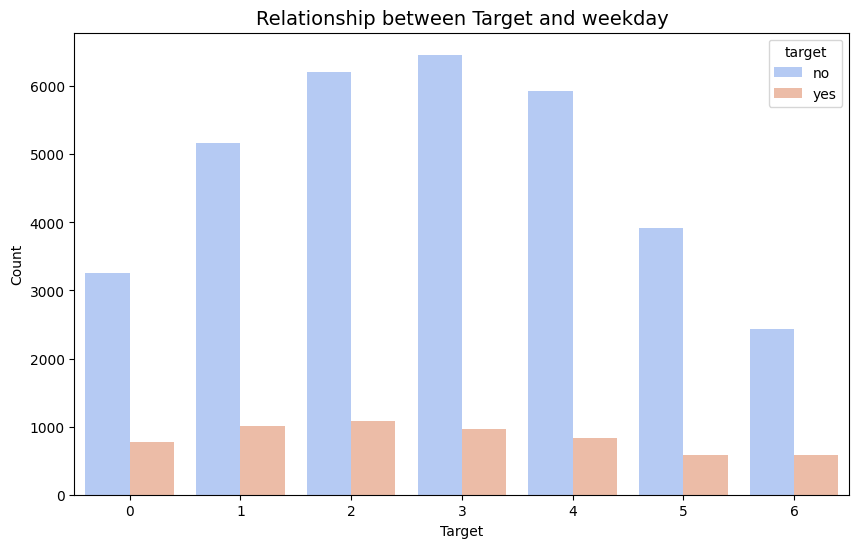

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='weekday', hue='target', data=train, palette="coolwarm")
plt.title('Relationship between Target and weekday',fontsize=14)
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

## Age and Target

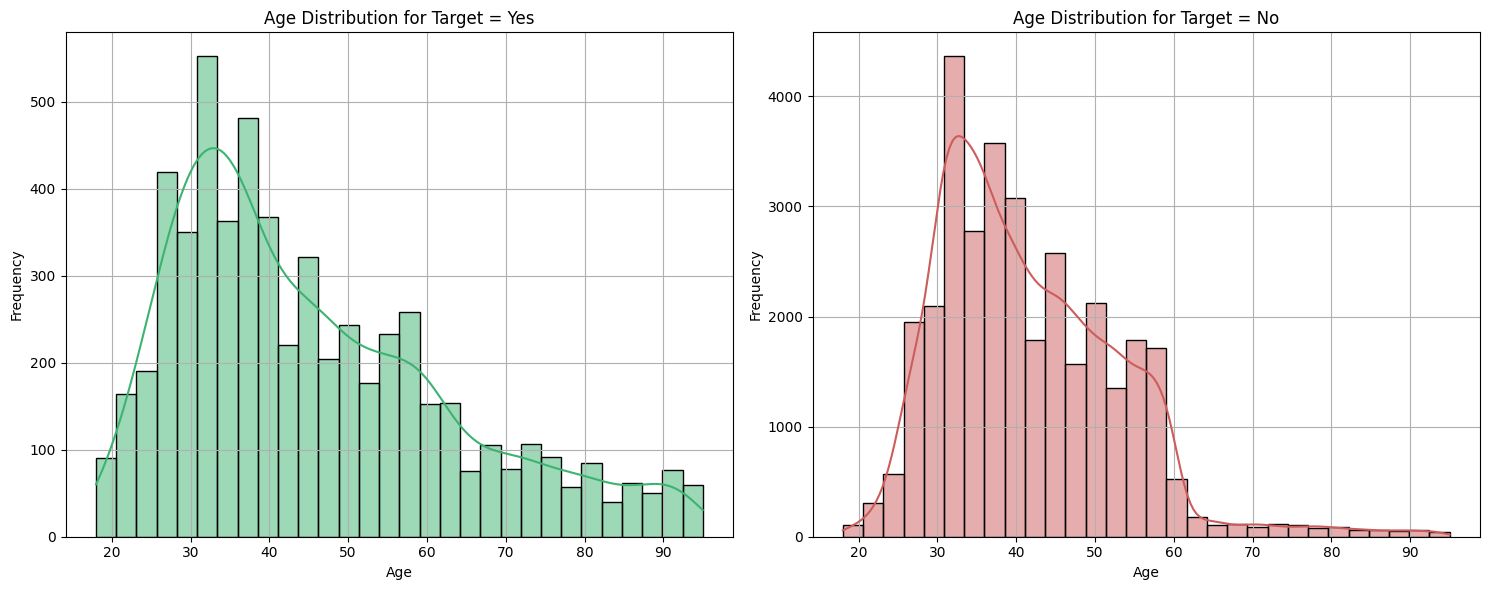

In [ ]:
import warnings
warnings.filterwarnings('ignore')

df = train
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

sns.histplot(data=df[df['target'] == 'yes'], x='age', bins=30, kde=True, color='mediumseagreen', ax=axes[0])
axes[0].set_title('Age Distribution for Target = Yes')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Frequency')
axes[0].grid(True)

sns.histplot(data=df[df['target'] == 'no'], x='age', bins=30, kde=True, color='indianred', ax=axes[1])
axes[1].set_title('Age Distribution for Target = No')
axes[1].set_xlabel('Age')
axes[1].set_ylabel('Frequency')
axes[1].grid(True)

plt.tight_layout()
plt.show()

## Insights

* clients who responded positively to the target ("Yes") are concentrated in the 30-40 age range, with a gradual decline as age increases,
* clients with a negative response ("No") also peak in the 30-40 age range but exhibit a broader distribution, with a significant portion in older age groups (50+), indicating lower engagement or success rates among older individuals.


## Job and Target

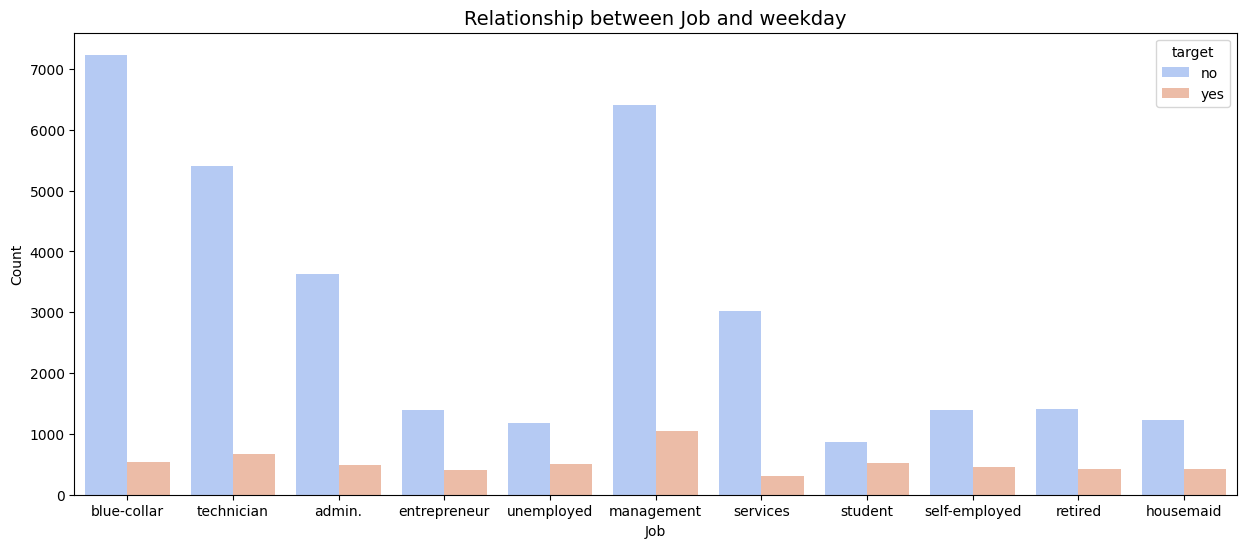

In [ ]:
plt.figure(figsize=(15, 6))
sns.countplot(x='job', hue='target', data=train, palette="coolwarm")
plt.title('Relationship between Job and weekday',fontsize=14)
plt.xlabel('Job')
plt.ylabel('Count')
plt.show()

## Insights

The dataset is dominated by **blue-collar (7776)**, **management (7462)**, and **technician (6078)** roles, with smaller groups in admin., services, and a few others.


## Box plot for numerical columns

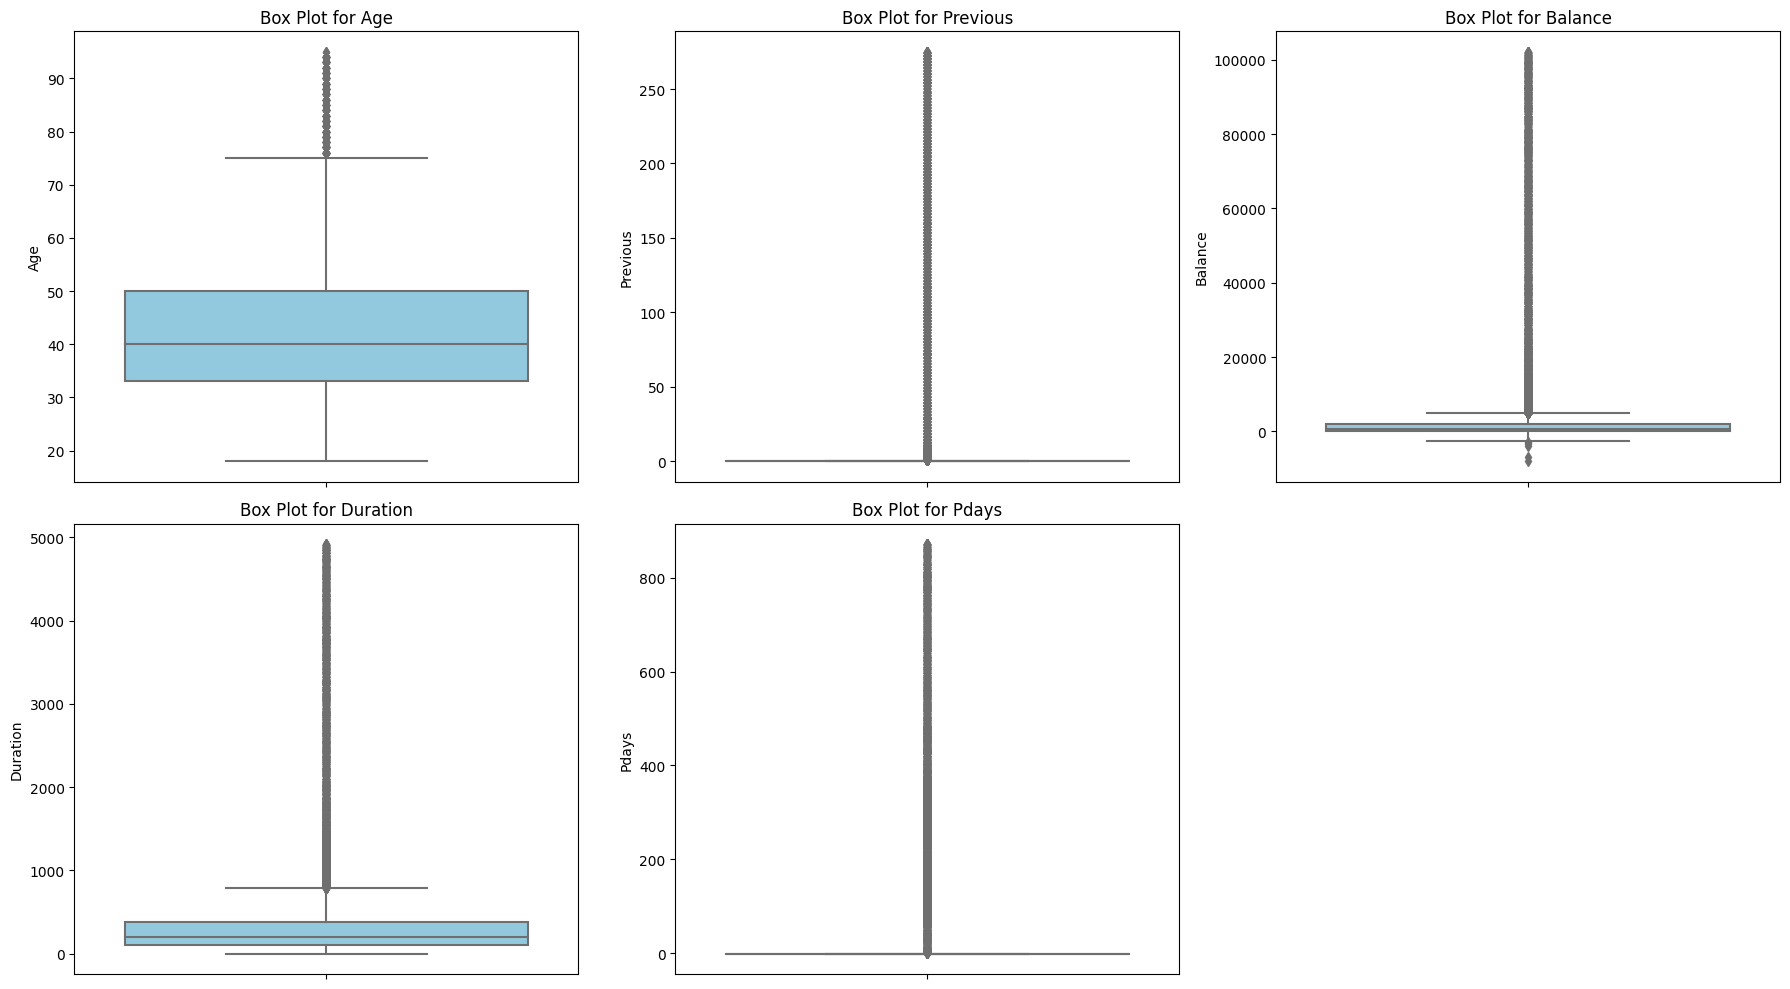

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))

columns = ['age', 'previous', 'balance', 'duration', 'pdays']
titles = ['Age', 'Previous', 'Balance', 'Duration', 'Pdays']

for i, (col, title) in enumerate(zip(columns, titles)):
    row, col_num = divmod(i, 3)
    sns.boxplot(data=df, y=col, ax=axes[row, col_num], color='skyblue')
    axes[row, col_num].set_title(f'Box Plot for {title}')
    axes[row, col_num].set_ylabel(title)

axes[1, 2].axis('off')

plt.tight_layout()
plt.show()


## Insights


1. Age: Most individuals are between 20-50 years, with few older outliers.
1. Previous: Most have few previous contacts, with some extreme outliers.
1. Balance: Wide range with extreme outliers, indicating a few high balances.
1. Duration: Most calls are short, but some have very long durations.
1. Pdays: Majority have no previous contact, with a few extreme outliers.

## Count Plot for Categorical Columns

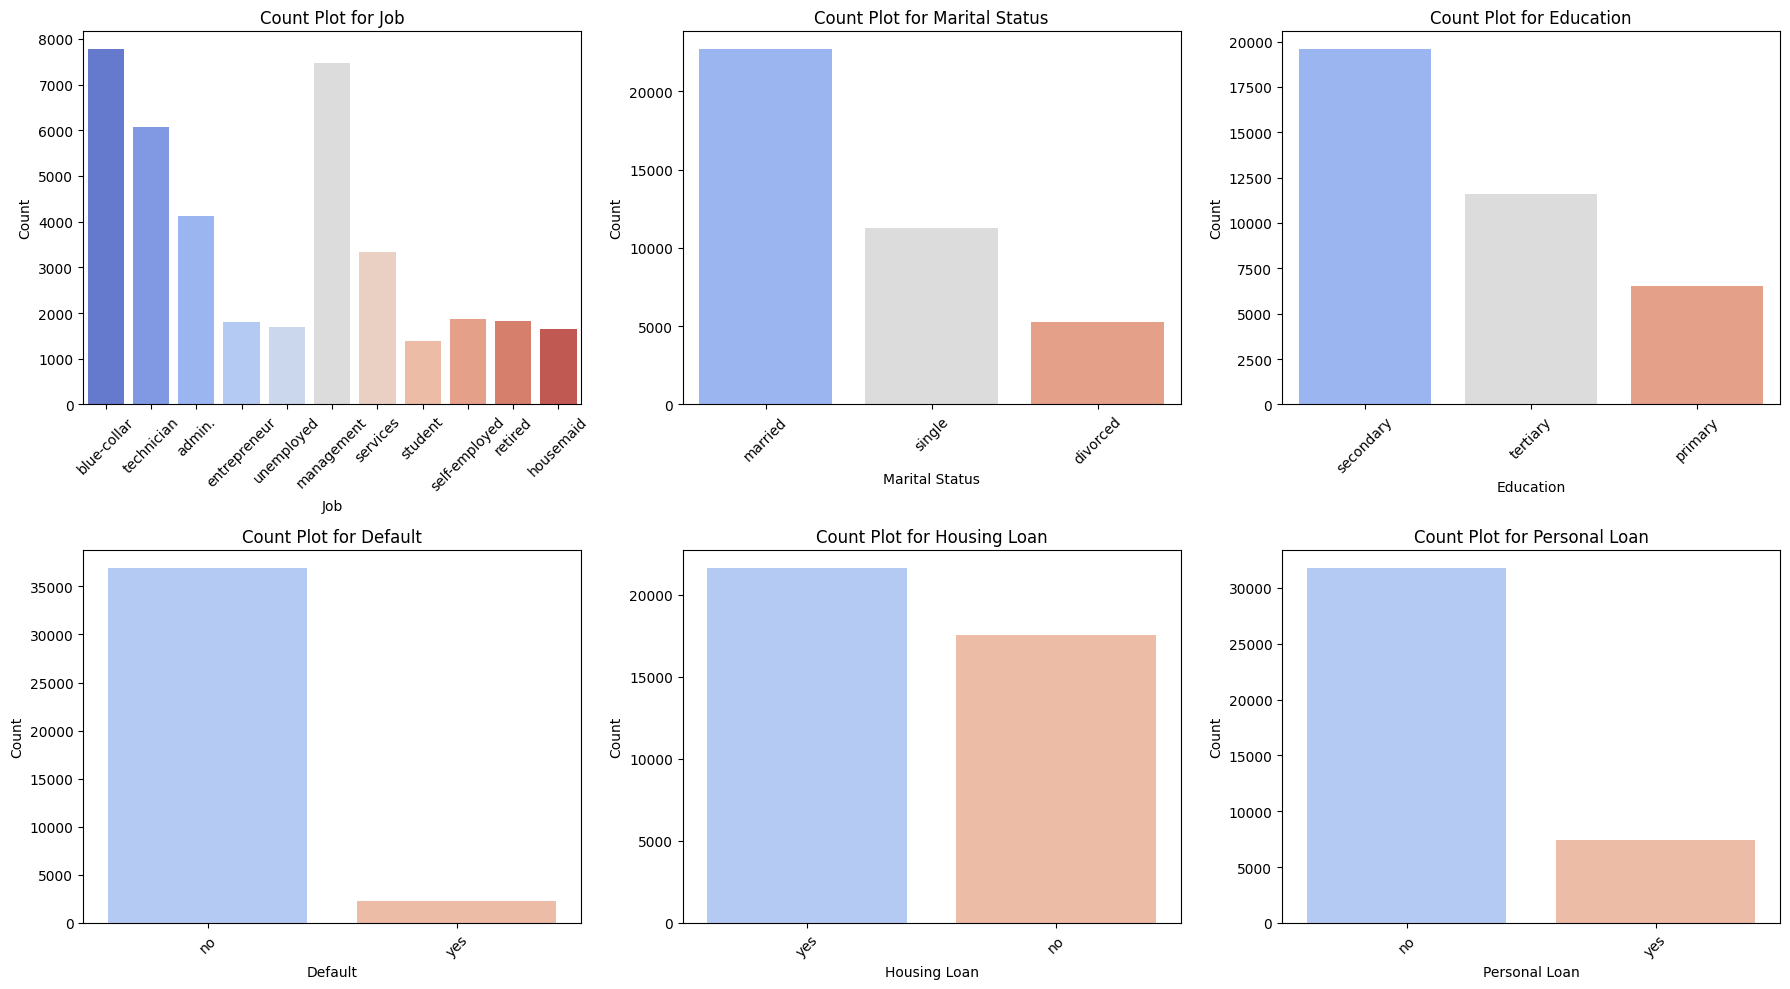

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))

categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan']
titles = ['Job', 'Marital Status', 'Education', 'Default', 'Housing Loan', 'Personal Loan']

for i, (col, title) in enumerate(zip(categorical_columns, titles)):
    row, col_num = divmod(i, 3)
    sns.countplot(data=df, x=col, ax=axes[row, col_num], palette='coolwarm')
    axes[row, col_num].set_title(f'Count Plot for {title}')
    axes[row, col_num].set_xlabel(title)
    axes[row, col_num].set_ylabel('Count')
    axes[row, col_num].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


## Insights

1. **Job:** The most common jobs are blue-collar, management, and technician.
1. **Marital Status:** The majority are married, followed by single, and a smaller portion is divorced.
1. **Education:** Most individuals have secondary education, followed by tertiary, and fewer with primary education.
1. **Default:** Most individuals do not have a default on their record.
1. **Housing Loan:** A majority have a housing loan, with a significant portion not having one.
1. **Personal Loan:** The majority do not have a personal loan.


## Scatter plots to display relationships between pairs of variables

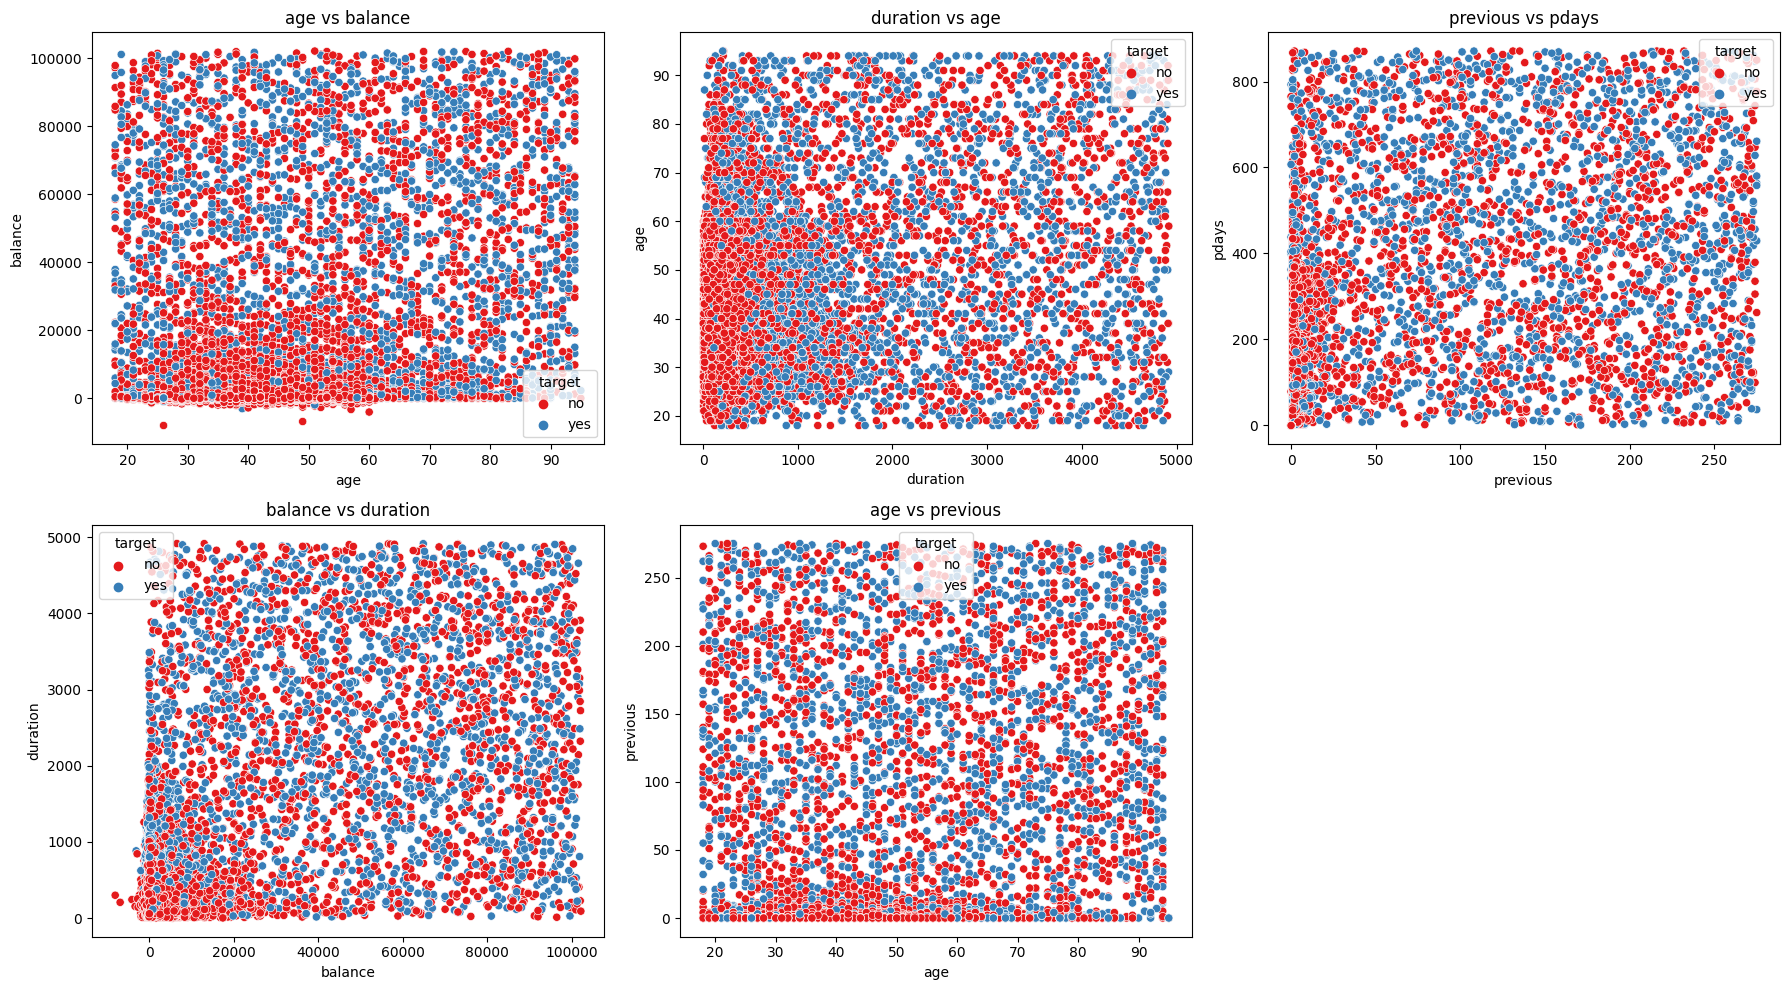

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))

numerical_columns = ['age', 'previous', 'balance', 'duration', 'pdays']
pairs = [('age', 'balance'), ('duration', 'age'),
         ('previous', 'pdays'), ('balance', 'duration'),
         ('age', 'previous')]

for i, (x_col, y_col) in enumerate(pairs):
    row, col_num = divmod(i, 3)
    sns.scatterplot(data=df, x=x_col, y=y_col, hue='target', ax=axes[row, col_num], palette='Set1')
    axes[row, col_num].set_title(f'{x_col} vs {y_col}')
    axes[row, col_num].set_xlabel(x_col)
    axes[row, col_num].set_ylabel(y_col)

axes[1, 2].axis('off')

plt.tight_layout()
plt.show()


## Insights

1. **Age vs Balance:** Higher balances are distributed across all age groups, with a slightly denser presence of "no" in higher balances.
1. **Duration vs Age:** Longer durations appear to be strongly associated with "yes" outcomes, while shorter durations mostly correspond to "no."
1. **Previous vs Pdays:** No clear pattern emerges, but both categories are scattered widely.
1. **Balance vs Duration:** Longer durations tend to favor "yes," especially at lower balances.
1. **Age vs Previous:** Both "yes" and "no" are distributed similarly, with no visible age-specific trend.



## Correlation matrix

***Correlation is a statistical measure that quantifies the strength and direction of a linear relationship between two variables, with a value ranging from -1 (perfect negative) to 1 (perfect positive).***

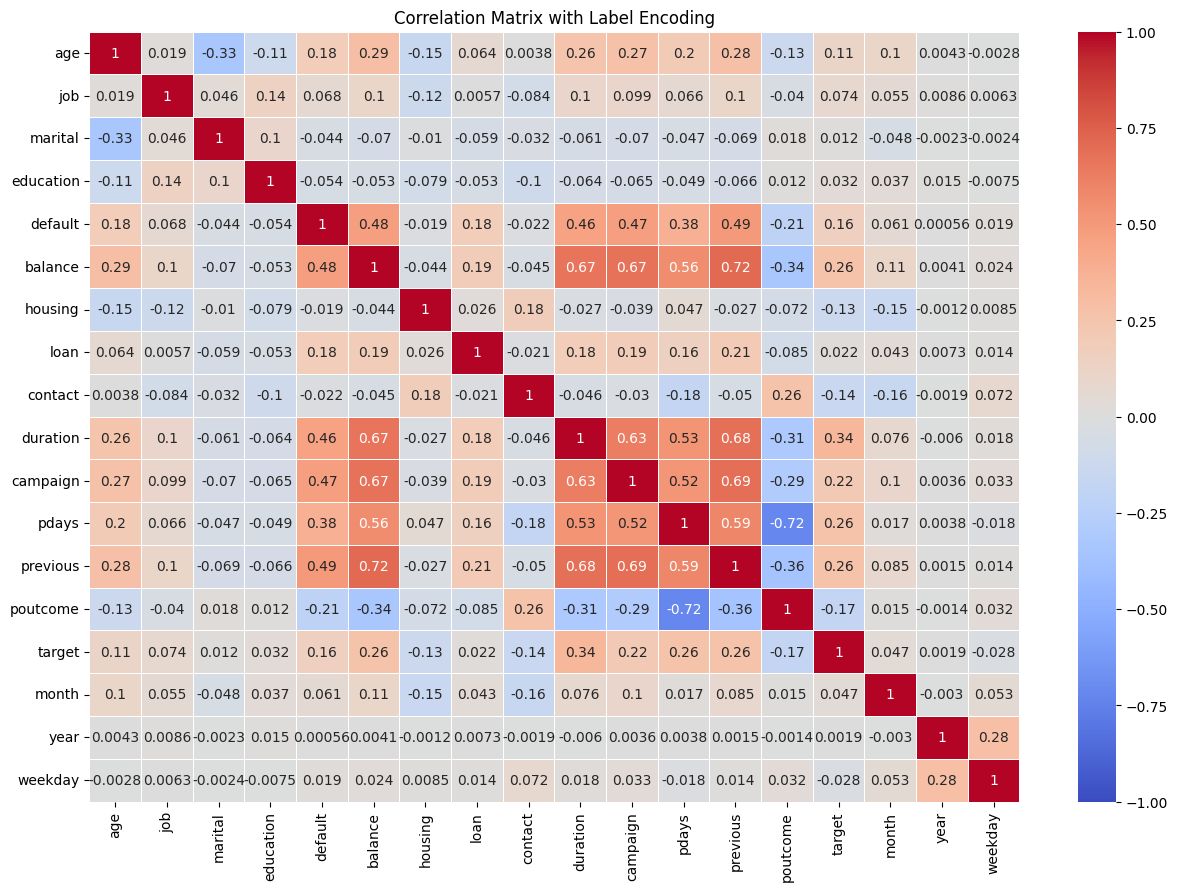

In [ ]:
encoded_df = df.copy()


categorical_columns = df.select_dtypes(include=['object']).columns.tolist()


label_encoder = LabelEncoder()   #categorical data into numerical format by assigning a unique integer to each category,

for col in categorical_columns:
    encoded_df[col] = label_encoder.fit_transform(encoded_df[col])

corr_matrix = encoded_df.corr()

plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Matrix with Label Encoding')
plt.show()


## Target distribution

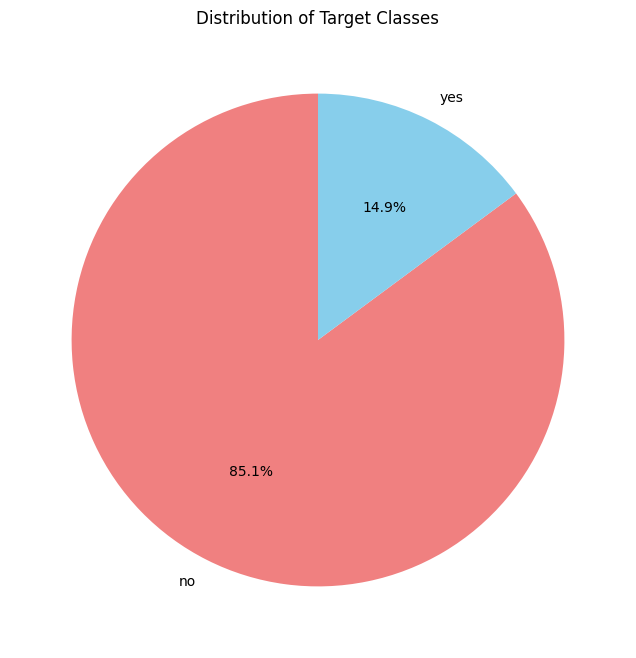

In [ ]:
target_counts = df['target'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(target_counts, labels=target_counts.index, autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'skyblue'])
plt.title('Distribution of Target Classes')
plt.show()


## Insights

1. **"No" (85.1%):** A large majority of the data belongs to the "no" category, indicating an imbalance in the dataset.
1. **"Yes" (14.9%):** A smaller portion of the data falls into the "yes" category.


# Imputation

#### **Imputation with mode**

In [ ]:
X,y = train.drop(columns=['target']),train['target']
cols = X.columns

Imputer  = SimpleImputer(strategy='most_frequent')   # replacing missing data
X = pd.DataFrame(Imputer.fit_transform(X),columns=cols)
test = pd.DataFrame(Imputer.transform(test),columns=cols)

In [ ]:
X

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,month,year,weekday
0,26,blue-collar,married,secondary,no,647,yes,no,cellular,357,2,331,1,other,4,2009,4
1,52,technician,married,secondary,no,553,yes,no,telephone,160,1,-1,0,failure,10,2009,6
2,44,blue-collar,married,secondary,no,1397,no,no,cellular,326,1,-1,0,failure,11,2010,5
3,33,admin.,married,secondary,no,394,yes,no,telephone,104,3,-1,0,failure,9,2009,1
4,31,entrepreneur,single,tertiary,no,137,no,no,cellular,445,2,-1,0,failure,1,2008,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39206,31,technician,single,secondary,no,0,yes,no,cellular,16,34,-1,0,failure,7,2008,3
39207,59,admin.,married,primary,no,6187,no,no,cellular,114,4,-1,0,failure,7,2009,4
39208,36,blue-collar,married,secondary,no,63,yes,no,cellular,56,8,-1,0,failure,6,2008,0
39209,28,student,single,secondary,no,5916,no,no,cellular,93,5,-1,0,failure,3,2010,5


In [ ]:
y

0         no
1         no
2         no
3         no
4         no
        ... 
39206     no
39207     no
39208     no
39209     no
39210    yes
Name: target, Length: 39211, dtype: object

In [ ]:
X.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
month        0
year         0
weekday      0
dtype: int64

#### Label Encoding

In [ ]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Train-Test Split

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val = train_test_split(X,y,test_size=0.2,stratify=y)

# Data Preprocessing and Feature Engineering

In [ ]:
categorical_col = ['marital','housing','loan','default','weekday','contact','education','job','poutcome']
numerical_col = ['age','previous','pdays','duration','balance']

Transformer = ColumnTransformer([('scale',StandardScaler(),numerical_col),
                                ('encode',OneHotEncoder(),categorical_col)],remainder='passthrough')

x_train_transformed = Transformer.fit_transform(x_train)
x_test_transformed = Transformer.transform(x_val)
x_test_transformed_final = Transformer.transform(test)

#### **Feature Selection**

#### RFE

In [ ]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(x_train_transformed, y_train)

selector_model = SelectFromModel(model, prefit=True, threshold="mean")
x_train_selected_model = selector_model.transform(x_train_transformed)
x_test_selected_model = selector_model.transform(x_test_transformed)
x_test_transformed_final_model = selector_model.transform(x_test_transformed_final)

selected_indices_model = selector_model.get_support(indices=True)

#### SelectKBest

In [ ]:
selector_f_classif = SelectKBest(score_func=f_classif, k=30)
x_train_selected_f_classif = selector_f_classif.fit_transform(x_train_transformed, y_train)
x_test_selected_f_classif = selector_f_classif.transform(x_test_transformed)
x_test_transformed_final_f_classif = selector_f_classif.transform(x_test_transformed_final)
selected_indices_f_classif = selector_f_classif.get_support(indices=True)
33

feature_names = list(Transformer.get_feature_names_out())
selected_features_f_classif = [feature_names[i] for i in selected_indices_f_classif]

print("Selected Features using f_classif:", selected_features_f_classif)

Selected Features using f_classif: ['scale__age', 'scale__previous', 'scale__pdays', 'scale__duration', 'scale__balance', 'encode__marital_divorced', 'encode__marital_married', 'encode__marital_single', 'encode__housing_no', 'encode__housing_yes', 'encode__default_no', 'encode__default_yes', 'encode__weekday_0', 'encode__contact_cellular', 'encode__contact_telephone', 'encode__education_secondary', 'encode__education_tertiary', 'encode__job_blue-collar', 'encode__job_entrepreneur', 'encode__job_housemaid', 'encode__job_retired', 'encode__job_self-employed', 'encode__job_services', 'encode__job_student', 'encode__job_unemployed', 'encode__poutcome_failure', 'encode__poutcome_other', 'encode__poutcome_success', 'remainder__campaign', 'remainder__month']


# Model Training

#### **Logistic Regression**

In [ ]:
log_reg = LogisticRegression(max_iter=1000, random_state=42)     # provide probability prediction,used to predict binary outcome
log_reg.fit(x_train_transformed, y_train)

y_pred = log_reg.predict(x_test_transformed)

print(classification_report(y_val, y_pred, target_names=['No', 'Yes']))   # linear eq. model the relationship b/w input features & the target

              precision    recall  f1-score   support

          No       0.88      0.97      0.92      6677
         Yes       0.57      0.23      0.32      1166

    accuracy                           0.86      7843
   macro avg       0.72      0.60      0.62      7843
weighted avg       0.83      0.86      0.83      7843



#### Selected with model features

In [ ]:
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(x_train_selected_model, y_train)

y_pred = log_reg.predict(x_test_selected_model)

print(classification_report(y_val, y_pred, target_names=['No', 'Yes']))

              precision    recall  f1-score   support

          No       0.87      0.98      0.92      6677
         Yes       0.55      0.17      0.26      1166

    accuracy                           0.86      7843
   macro avg       0.71      0.57      0.59      7843
weighted avg       0.82      0.86      0.82      7843



#### Selected with f_classif features

In [ ]:
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(x_train_selected_f_classif, y_train)

y_pred = log_reg.predict(x_test_selected_f_classif)

print(classification_report(y_val, y_pred, target_names=['No', 'Yes']))

              precision    recall  f1-score   support

          No       0.88      0.97      0.92      6677
         Yes       0.56      0.22      0.31      1166

    accuracy                           0.86      7843
   macro avg       0.72      0.59      0.62      7843
weighted avg       0.83      0.86      0.83      7843



#### **XGBoost**

**XGBoost (Extreme Gradient Boosting) is a high-performance machine learning algorithm based on Gradient Boosting. It builds models sequentially by combining weak learners (usually decision trees) to improve predictions, making it highly accurate and efficient.**

In [ ]:
model = XGBClassifier()   #XGBoost is more stable and versatile, especially on smaller datasets or where interpretability matters.

model.fit(x_train_transformed, y_train)

y_pred = model.predict(x_test_transformed)

print(classification_report(y_val, y_pred, target_names=['No', 'Yes']))

              precision    recall  f1-score   support

          No       0.91      0.94      0.92      6677
         Yes       0.58      0.49      0.53      1166

    accuracy                           0.87      7843
   macro avg       0.74      0.71      0.73      7843
weighted avg       0.86      0.87      0.87      7843



## Cleared Cutoff with XGB and probability twiking

In [ ]:
probability = model.predict_proba(x_test_transformed)
p_proba=probability[:,1]
preds=(p_proba >= 0.24).astype(int)
print(classification_report(y_val,preds))

              precision    recall  f1-score   support

           0       0.96      0.86      0.90      6677
           1       0.49      0.77      0.60      1166

    accuracy                           0.85      7843
   macro avg       0.72      0.82      0.75      7843
weighted avg       0.89      0.85      0.86      7843



**LGBMClassifier**

In [ ]:
from lightgbm import LGBMClassifier  #LightGBM is faster and more memory-efficient, ideal for large datasets.

model = LGBMClassifier()
model.fit(x_train_transformed, y_train)

y_pred = model.predict(x_test_transformed)

print(classification_report(y_val, y_pred, target_names=['No', 'Yes']))

[LightGBM] [Info] Number of positive: 4661, number of negative: 26707
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005726 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1236
[LightGBM] [Info] Number of data points in the train set: 31368, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148591 -> initscore=-1.745696
[LightGBM] [Info] Start training from score -1.745696
              precision    recall  f1-score   support

          No       0.92      0.93      0.92      6677
         Yes       0.57      0.51      0.54      1166

    accuracy                           0.87      7843
   macro avg       0.74      0.72      0.73      7843
weighted avg       0.86      0.87      0.87      7843



In [ ]:
probability = model.predict_proba(x_test_transformed)
p_proba=probability[:,1]
preds=(p_proba >= 0.24).astype(int)
print(classification_report(y_val,preds))

              precision    recall  f1-score   support

           0       0.97      0.85      0.90      6677
           1       0.49      0.83      0.62      1166

    accuracy                           0.85      7843
   macro avg       0.73      0.84      0.76      7843
weighted avg       0.90      0.85      0.86      7843



### Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(x_train_transformed, y_train)

y_pred = model.predict(x_test_transformed)

print(classification_report(y_val, y_pred, target_names=['No', 'Yes']))

              precision    recall  f1-score   support

          No       0.91      0.90      0.90      6677
         Yes       0.44      0.46      0.45      1166

    accuracy                           0.83      7843
   macro avg       0.67      0.68      0.68      7843
weighted avg       0.84      0.83      0.84      7843



# HyperParameter Tuning

### **LOG REG HPT**

In [ ]:
# warnings.filterwarnings('ignore')

# from sklearn.model_selection import GridSearchCV


# param_grid = {
#     'C': [0.01, 0.1, 1, 10, 100],
#     'penalty': ['l1', 'l2', 'elasticnet', 'none'],
#     'solver': ['liblinear']
# }

# model = LogisticRegression(max_iter=1000)

# grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1_macro',verbose=3)

# grid_search.fit(x_train_transformed, y_train)

# best_params = grid_search.best_params_
# print("Best parameters found: ", best_params)

# best_model = grid_search.best_estimator_
# y_pred = best_model.predict(x_test_transformed)

# print(classification_report(y_val, y_pred, target_names=['No', 'Yes']))

![image.png](attachment:18b72d5f-ce21-4992-bce3-3f3c4ac98016.png)

### **XGBoost HPT**

In [ ]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'learning_rate': [0.01, 0.05, 0.1],
#     'max_depth': [-1, 5, 10, 20],
#     'n_estimators': [100, 200, 300]
# }

# model = XGBClassifier()

# grid_search = GridSearchCV(model, param_grid, cv=3, scoring='f1_macro',verbose=3)

# grid_search.fit(x_train_transformed, y_train)

# best_params = grid_search.best_params_
# print("Best parameters found: ", best_params)

# best_model = grid_search.best_estimator_
# y_pred = best_model.predict(x_test_transformed)

# print(classification_report(y_val, y_pred, target_names=['No', 'Yes']))


![image.png](attachment:d956dc6f-db10-4191-ab07-d2f5a73d2d86.png)

### **LGBM HPT**

In [ ]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'learning_rate': [0.01, 0.1, 0.2],
#     'n_estimators': [100, 200, 300],
#     'max_depth': [-1, 5, 10],
# }

# model = LGBMClassifier()

# grid_search = GridSearchCV(model, param_grid, cv=3, scoring='f1_macro',verbose=3)

# grid_search.fit(x_train_transformed, y_train)

# best_params = grid_search.best_params_
# print("Best parameters found: ", best_params)

# best_model = grid_search.best_estimator_
# y_pred = best_model.predict(x_test_transformed)

# print(classification_report(y_val, y_pred, target_names=['No', 'Yes']))


![image.png](attachment:7d4861e9-5759-4dba-832d-4436569303c6.png)

### light gbm
* For large datasets with many features.
* When speed and memory efficiency are critical.
* When handling categorical features directly is needed.

### XGBoost:

* For smaller or medium-sized datasets.
* When stability and reduced risk of overfitting are more important.
* For datasets where level-wise tree growth performs better.


# Model Evaluation

### **XGB**

              precision    recall  f1-score   support

           0       0.96      0.86      0.90      6677
           1       0.49      0.77      0.60      1166

    accuracy                           0.85      7843
   macro avg       0.72      0.82      0.75      7843
weighted avg       0.89      0.85      0.86      7843



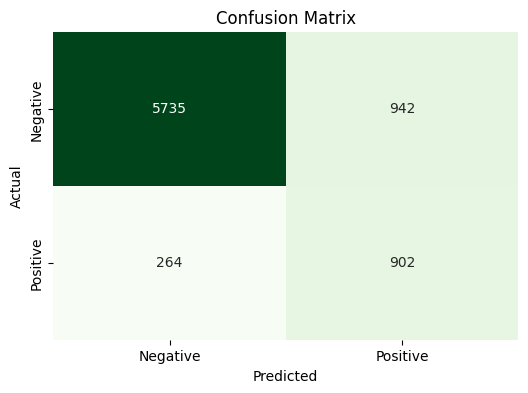

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
model = XGBClassifier()
model.fit(x_train_transformed, y_train)

y_pred = model.predict(x_test_transformed)
y_pred_proba = model.predict_proba(x_test_transformed)[:, 1]
y_pred=(y_pred_proba >= 0.24).astype(int)

print(classification_report(y_val, y_pred))

cm = confusion_matrix(y_val, y_pred)    #performance of a classification model by comparing predicted vs. actual outcomes.
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### **Logistic Regression**

              precision    recall  f1-score   support

           0       0.90      0.93      0.92      6677
           1       0.53      0.43      0.48      1166

    accuracy                           0.86      7843
   macro avg       0.72      0.68      0.70      7843
weighted avg       0.85      0.86      0.85      7843



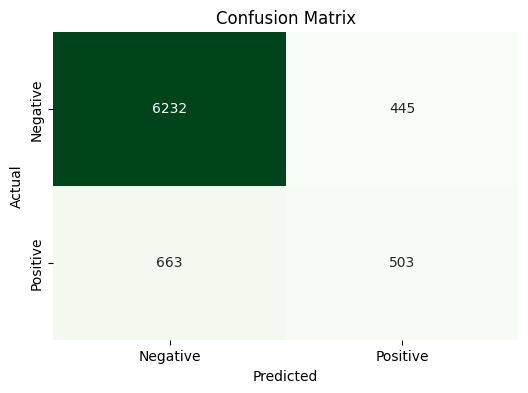

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
model = LogisticRegression()
model.fit(x_train_transformed, y_train)

y_pred = model.predict(x_test_transformed)
y_pred_proba = model.predict_proba(x_test_transformed)[:, 1]
y_pred=(y_pred_proba >= 0.24).astype(int)

print(classification_report(y_val, y_pred))

cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### **XGB Tunned**

              precision    recall  f1-score   support

           0       0.96      0.86      0.91      6677
           1       0.50      0.79      0.61      1166

    accuracy                           0.85      7843
   macro avg       0.73      0.82      0.76      7843
weighted avg       0.89      0.85      0.86      7843



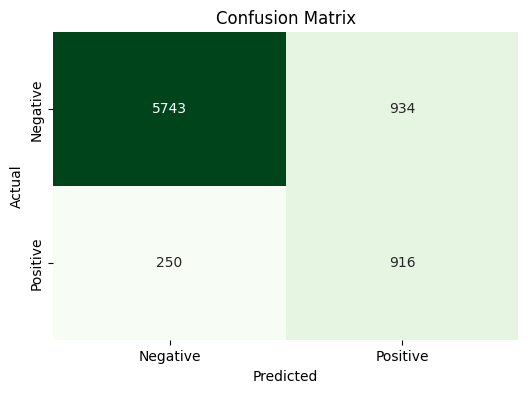

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
model = XGBClassifier(learning_rate=0.1,max_depth=10,n_estimators=100)
model.fit(x_train_transformed, y_train)

y_pred = model.predict(x_test_transformed)
y_pred_proba = model.predict_proba(x_test_transformed)[:, 1]
y_pred=(y_pred_proba >= 0.24).astype(int)

print(classification_report(y_val, y_pred))

cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### **LGBM Tunned**

[LightGBM] [Info] Number of positive: 4661, number of negative: 26707
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004804 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1236
[LightGBM] [Info] Number of data points in the train set: 31368, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148591 -> initscore=-1.745696
[LightGBM] [Info] Start training from score -1.745696
              precision    recall  f1-score   support

           0       0.97      0.85      0.91      6677
           1       0.50      0.82      0.62      1166

    accuracy                           0.85      7843
   macro avg       0.73      0.84      0.76      7843
weighted avg       0.90      0.85      0.86      7843



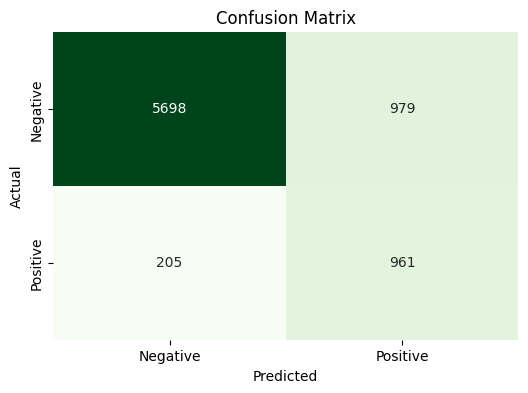

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
model = LGBMClassifier(learning_rate=0.2,max_depth=-1,n_estimators=100)
model.fit(x_train_transformed, y_train)

y_pred = model.predict(x_test_transformed)
y_pred_proba = model.predict_proba(x_test_transformed)[:, 1]
y_pred=(y_pred_proba >= 0.24).astype(int)

print(classification_report(y_val, y_pred))

cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Model Comparision

[LightGBM] [Info] Number of positive: 4661, number of negative: 26707
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004784 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1236
[LightGBM] [Info] Number of data points in the train set: 31368, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148591 -> initscore=-1.745696
[LightGBM] [Info] Start training from score -1.745696


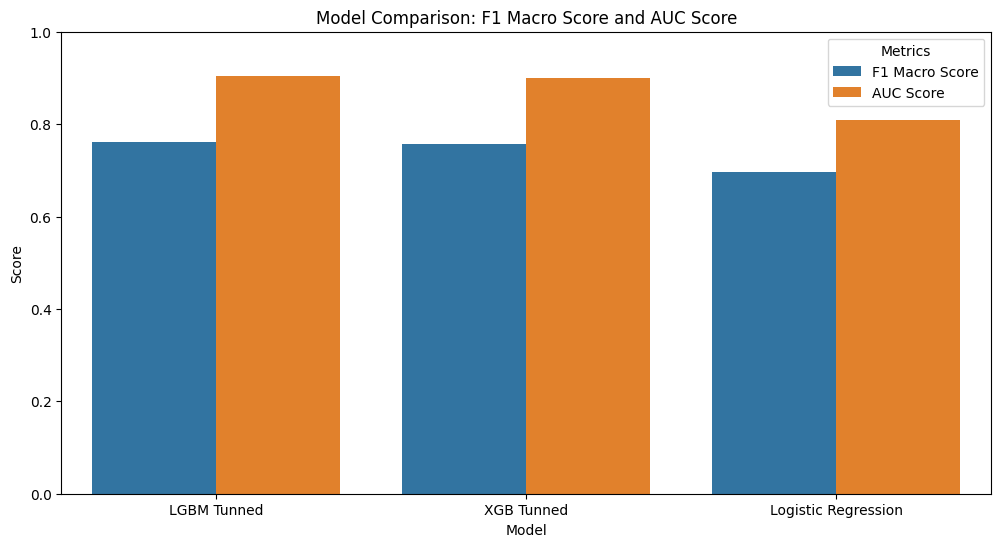

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, f1_score

models = {
    'LGBM Tunned': LGBMClassifier(learning_rate=0.2, max_depth=-1, n_estimators=100),
    'XGB Tunned': XGBClassifier(learning_rate=0.1, max_depth=10, n_estimators=100),
    'Logistic Regression': LogisticRegression()
}

metrics = {'Model': [], 'F1 Macro Score': [], 'AUC Score': []}

for model_name, model in models.items():
    model.fit(x_train_transformed, y_train)

    y_pred = model.predict(x_test_transformed)
    y_pred_proba = model.predict_proba(x_test_transformed)[:, 1]
    y_pred_thresholded = (y_pred_proba >= 0.24).astype(int)

    f1_macro = f1_score(y_val, y_pred_thresholded, average='macro')
    auc = roc_auc_score(y_val, y_pred_proba)

    metrics['Model'].append(model_name)
    metrics['F1 Macro Score'].append(f1_macro)
    metrics['AUC Score'].append(auc)

metrics_df = pd.DataFrame(metrics)

plt.figure(figsize=(12, 6))
sns.barplot(data=metrics_df.melt(id_vars='Model'), x='Model', y='value', hue='variable')
plt.title('Model Comparison: F1 Macro Score and AUC Score')
plt.ylabel('Score')
plt.xlabel('Model')
plt.ylim(0, 1)
plt.legend(title='Metrics')
plt.show()


# Final Submission

x_test_transformed_final = Transformer.transform(test)

In [ ]:
x_train_final = Transformer.fit_transform(X)
x_test_final = Transformer.transform(test)

In [ ]:
final_model = LGBMClassifier(learning_rate=0.2, max_depth=-1, n_estimators=100)
final_model.fit(x_train_final, y)

probs = final_model.predict_proba(x_test_final)[:, 1]

preds = (probs >= 0.24).astype(int)

[LightGBM] [Info] Number of positive: 5827, number of negative: 33384
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005948 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1238
[LightGBM] [Info] Number of data points in the train set: 39211, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.148606 -> initscore=-1.745574
[LightGBM] [Info] Start training from score -1.745574


In [ ]:
submission = pd.DataFrame({"id": range(0,x_test_final.shape[0]),
                           "target": label_encoder.inverse_transform(preds)})

submission.to_csv('submission.csv', index = False)